In [ ]:
!pip install selenium

Собираем ссылки на продукты/товары/услуги
---

1. Выбранный сайт для парсинга "https://irecommend.ru".


2. Отзывы на нем разделены по темам, из каждой темы возьмем примерно по 100 отзывов. Тем всего 10. Итого должно получиться ~ 1000 отзывов.


3. Количество отзывов для каждого продукта сильно разниться - от 1 до порой более 600 отзывов. Попытаемся сделать выборку более сбалансированной и отберем продукты с 10-25 отзывами.


4. Наконец для каждой темы найдем ссылки на такие товары, чтобы отзывов на каждую тему получилось от 100 штук.


5. Ссылки сложим в файл `links.txt`

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By

In [2]:
import time
import random

In [195]:
def get_info_from_site(browser):
    # Find the recommendation count for all products on page
    recommend_count = browser.find_elements(By.CLASS_NAME, "counter")
    rc_storage = []
    for rc_el in recommend_count:
        browser.execute_script("return arguments[0].scrollIntoView(true);", rc_el)
        if random.randint(1, 999) % 2:
            time.sleep(1)
        else:
            time.sleep(random.random())
        try:
            rc_el_ta = int(rc_el.text)
            rc_storage.append(rc_el_ta)
        except ValueError:
            continue

    # Find the link to page with all recommendations for each product
    page_link = browser.find_elements(
        By.CLASS_NAME, 
        "read-all-reviews-link-bottom.read-all-reviews-link"
        )

    # Generate list of links with 10-20 recommendations
    if len(rc_storage) == len(page_link):
        useful_links = [a.get_attribute("href") for i, a in enumerate(page_link) if 10 <= rc_storage[i] <= 25]
        found_rec_count = sum([r for r in rc_storage if 10 <= r <= 25])
    else:
        useful_links = []

    # Find next page to go
    neighbour_page = browser.find_elements(By.CSS_SELECTOR, 
                                          ".pager-item-neighbor-1 a")
    neighbour_page_link = neighbour_page[-1].get_attribute("href")
    
    return useful_links, found_rec_count, neighbour_page_link

In [196]:
# Start browser session
browser = webdriver.Chrome()

In [197]:
# Get first topic link
link = "https://irecommend.ru/catalog/list/6"
browser.get(link)

In [128]:
# Find all recommendation topics presented on the site
topics = browser.find_elements(By.CSS_SELECTOR, 
                               ".IrecUiNavbar.desktopStuff a")[:-1]
# Save topic names
topics_text = [t.text for t in topics]
# Save links to these topics
topics_links = [t.get_attribute("href") for t in topics]

In [198]:
# dictionary {'topic': [links_to_products]}
all_topic_storage = {}

for i in range(len(topics)):
    if i != 0:
        link = topics_links[i]
        browser.get(link)
        
    rec_to_topic_counter = 0
    recommendation_link_storage = []
    
    while rec_to_topic_counter <= 100:
        links_to_go, rec_count, next_page_to_go = get_info_from_site(browser)
        rec_to_topic_counter += rec_count
        recommendation_link_storage.append(links_to_go)
        time.sleep(random.randint(2, 5))
        browser.get(next_page_to_go)
        
    all_topic_storage[topics_text[i]] = recommendation_link_storage

In [199]:
# Quit browser session
browser.quit()

In [105]:
# Flatten list of product links
def flatten(l):
    return [item for sublist in l for item in sublist]

In [200]:
# Write links to file
with open("links.txt", 'w', encoding='utf-8') as file:
    for k in all_topic_storage.keys():
        links = flatten(all_topic_storage[k])
        link_key_tuples = list(map(lambda x: (k, x), links))
        link_key_str = ['; '.join(t) for t in link_key_tuples]
        file.write('\n'.join(link_key_str))
        file.write('\n')

Собираем ссылки на сами отзывы
---

1. Открываем страницу продукта.


2. Получаем его категорию и наименование.


3. Собираем все ссылки на отзывы.


4. Последовательно открываем их и забираем сам текст отзыва (без заголовка - тексты отзыва достаточно длинные (обычно от 3 абзацев)).


5. Записываем в файл название темы - название категории - наименование товара - отзыв.

In [3]:
# Start browser session
browser = webdriver.Chrome()

In [6]:
# Save selector for finding all links to product review
going_on_recommend_page = (By.CSS_SELECTOR, ".list-comments :nth-child(1) div.reviewTextSnippet a") # all links presented

In [4]:
# Get the review text without button text "Показать цитаты"
def get_rec_text(browser):
    browser.implicitly_wait(6)
    el = browser.find_element(By.CSS_SELECTOR, ".views-field-teaser :nth-child(1)")
    browser.execute_script("return arguments[0].scrollIntoView(true);", el)
    rec_text = el.text
    return rec_text.replace("\nПоказать цитату", "")

In [7]:
# Open file with links
with open('links.txt', encoding='utf-8') as file:
    for line in file:
        if line:
            tag, link = line.split('; ')
            
            # Open link to page with all product reviews
            browser.get(link)
            time.sleep(random.random() + random.randint(1, 3))
            
            # Collect product info: category, name, links to reviews
            category = browser.find_element(By.CSS_SELECTOR, ".voc-group.vid-1 a").text
            product_name = browser.find_element(By.CSS_SELECTOR, "span.fn").text
            data_template = [tag, category, product_name]
            recommendation_links = [l.get_attribute("href") for l in browser.find_elements(*going_on_recommend_page)
                                   if l.is_displayed()]
            
            # get the review text for each review link and write to file
            for r_link in recommendation_links:
                browser.get(r_link)
                browser.implicitly_wait(5)
                review = get_rec_text(browser)
                time.sleep(random.random() + random.randint(1, 3))
                with open("data.txt", 'a', encoding='utf-8') as f:
                    f.write('\t'.join(data_template + [review]))
                    f.write('\n')
                    
            time.sleep(5)

# Quit browser session
browser.quit()

Считываем и очищаем данные
---

1. Пишем генератор `dataset_generator` для считывания данных из файла (чтобы не хранить в памяти весь объем текстового файла):
    - принимает на вход открытый файл,
    - проходится по его строкам,
    - записывает в переменную для возврата строку, если она не первая и в ней нет знака табуляции с названием темы,
    - возвращает отзыв со всеми данными о нем (без конечного переноса строки).
    
    
2. Убираем дубликаты из датасета


3. Смотрим, что вообще получилось

In [66]:
import pandas as pd

In [45]:
# All topics that we chose
TOPICS = ['Красота и здоровье\t', 
          'Детское\t', 
          'Техника\t',
          'Туризм\t',
          'Животные\t',
          'Кино\t',
          'Книги\t',
          'Продукты\t',
          'Посуда\t',
          'Авто\t'
         ]

In [64]:
def dataset_generator(file_text):
    text_to_return = ''
    new = True
    global TOPICS
    for line in file_text.readlines():
        # sum([True, False, False, ...]) проверяет, есть ли в строке название темы и знак табуляции
        if not new and sum([t in line for t in TOPICS]):
            yield text_to_return[:-1]
            text_to_return = ''
        text_to_return += line
        new = False
    yield text_to_return[:-1]

In [110]:
# Create DataFrame for our reviews
reviewDf = pd.DataFrame(columns=['topic', 'subtopic', 'product name', 'review'])

In [111]:
# Fill data from file using generator `dataset_generator`
data_file = open('data.txt', encoding='utf-8')

for review_info in dataset_generator(data_file):
    if reviewDf.index.empty:
        reviewDf.loc[0] = review_info.split('\t')
    else:
        reviewDf.loc[reviewDf.index[-1] + 1] = review_info.split('\t')
        
data_file.close()

In [112]:
reviewDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 0 to 1556
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   topic         1557 non-null   object
 1   subtopic      1557 non-null   object
 2   product name  1557 non-null   object
 3   review        1557 non-null   object
dtypes: object(4)
memory usage: 60.8+ KB


In [116]:
reviewDf.drop_duplicates(inplace=True)

In [117]:
reviewDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1528 entries, 0 to 1556
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   topic         1528 non-null   object
 1   subtopic      1528 non-null   object
 2   product name  1528 non-null   object
 3   review        1528 non-null   object
dtypes: object(4)
memory usage: 59.7+ KB


In [124]:
df_topics = ' = '.join(reviewDf['topic'].unique())

print(f'''У нас есть отзывы по следующим темам:
{df_topics}

Всего товаров рассмотрено: {len(reviewDf['product name'].unique())}
Всего категорий товаров: {len(reviewDf['subtopic'].unique())}''')

У нас есть отзывы по следующим темам:
Красота и здоровье = Детское = Техника = Туризм = Животные = Кино = Книги = Продукты = Посуда = Авто

Всего товаров рассмотрено: 96
Всего категорий товаров: 26


In [130]:
import random

rev_text = reviewDf['review'].loc[random.randint(0, 1500)]
print(f'Пример рандомного отзыва:\n===\n{rev_text}')

Пример рандомного отзыва:
===
- Папа! А что такое ремикс?
- Это,деточка,когда идей новых нет,а кушать очень хочется!
(с)
После продолжения Звёздных войн от Дисней я подумал,что падать ниже некуда.
Но потом вышел Мандалорец.И Звёздные войны уже показались и не таким уж и отстоем.Вот она - нижняя планка.Куда уже дальше? И тут нам снизу постучали...
Блин! Нет предела двум вещам: человеческой любознательности и человеческой глупости.Сначала подумал,что я уже вырос и просто воспринимаю этот фильм с позиции пережитых эмоций от старого мультфильма.Но ,как оказалось,я ошибся.Даже мой ребёнок не смог посмотреть этот шедевр дольше 15-ти минут и попросил что-нибудь другое.
Ждём новых творений от Дисней.С ужасом.И очередной раз спрашиваю: - Зачем?


Готовим тексты отзывов
---

1. Выбираем токенайзер


2. Пишем функцию предобработки отзывов:
    * убираем те "Показать цитату", которые не убрались на этапе записи (из-за пробела в начале),
    * убираем попавшие в тексты отзывов ссылки,
    * убираем апострофы (’), потому что встречаются слова вроде _об’ясняем_ (имитация детского произношения) и еще названия брендов с апострофом,
    * токенизируем получившийся текст,
    * оставляем в нем только слова из букв и слова с дефисом
    
    
3. Применяем функцию к датасету

In [ ]:
! pip install natasha

In [ ]:
! pip install nltk

In [133]:
import re
from natasha import Doc, Segmenter
from nltk.tokenize import word_tokenize, wordpunct_tokenize, TweetTokenizer, TreebankWordTokenizer

In [137]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\PC
[nltk_data]     Natalya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [162]:
review = reviewDf['review'].loc[random.randint(0, 1500)]

**! Сложный случай:** 

`...и в то же время не разваливается.Горошек сладкий...`

In [163]:
' = '.join(word_tokenize(review))

'Здравствуйте = . = Горошек = зелёный = консервированный = я = беру = часто = в = этот = рас = выбор = пал = на = баночку = кубаночку = . = Баночка = стеклянная = что = мне = очень = нравится = можно = разглядеть = содержимое = . = Горошка = по = плечики = не = так = как = бывает = у = других = производителей = откроешь = а = там = и = половины = нет = одна = водичка.Водичка = кстати = прозрачная = горошины = красивые = одна = под = одну = . = Очень = нежный = , = мягкий = и = в = то = же = время = не = разваливается.Горошек = сладкий = как = только = открыла = детки = слопали = пришлось = за = второй = бежать = уж = сильно = салата = хотелось.Чистый = без = мусора = и = кусочков = листиков = и = усиков.Переспевших = горошинок = не = попадалось = как = у = некоторых = других = марок = . = Отлично = подходит = не = только = в = салаты = можно = так = ложкой = кушать = можно = к = картошке = или = макаронам = очень = вкусный = мне = и = моей = семье = понравился = . = Спасибо = за = вним

__Не отлавливается:__ токен `'разваливается.Горошек'`

In [164]:
' = '.join(wordpunct_tokenize(review))

'Здравствуйте = . = Горошек = зелёный = консервированный = я = беру = часто = в = этот = рас = выбор = пал = на = баночку = кубаночку = . = Баночка = стеклянная = что = мне = очень = нравится = можно = разглядеть = содержимое = . = Горошка = по = плечики = не = так = как = бывает = у = других = производителей = откроешь = а = там = и = половины = нет = одна = водичка = . = Водичка = кстати = прозрачная = горошины = красивые = одна = под = одну = . = Очень = нежный = , = мягкий = и = в = то = же = время = не = разваливается = . = Горошек = сладкий = как = только = открыла = детки = слопали = пришлось = за = второй = бежать = уж = сильно = салата = хотелось = . = Чистый = без = мусора = и = кусочков = листиков = и = усиков = . = Переспевших = горошинок = не = попадалось = как = у = некоторых = других = марок = . = Отлично = подходит = не = только = в = салаты = можно = так = ложкой = кушать = можно = к = картошке = или = макаронам = очень = вкусный = мне = и = моей = семье = понравился =

__Отлавливается:__ токены `'разваливается', '.', 'Горошек'`

In [165]:
' = '.join(TweetTokenizer().tokenize(review))

'Здравствуйте = . = Горошек = зелёный = консервированный = я = беру = часто = в = этот = рас = выбор = пал = на = баночку = кубаночку = . = Баночка = стеклянная = что = мне = очень = нравится = можно = разглядеть = содержимое = . = Горошка = по = плечики = не = так = как = бывает = у = других = производителей = откроешь = а = там = и = половины = нет = одна = водичка = . = Водичка = кстати = прозрачная = горошины = красивые = одна = под = одну = . = Очень = нежный = , = мягкий = и = в = то = же = время = не = разваливается = . = Горошек = сладкий = как = только = открыла = детки = слопали = пришлось = за = второй = бежать = уж = сильно = салата = хотелось = . = Чистый = без = мусора = и = кусочков = листиков = и = усиков = . = Переспевших = горошинок = не = попадалось = как = у = некоторых = других = марок = . = Отлично = подходит = не = только = в = салаты = можно = так = ложкой = кушать = можно = к = картошке = или = макаронам = очень = вкусный = мне = и = моей = семье = понравился =

__Отлавливается__

In [166]:
' = '.join(TreebankWordTokenizer().tokenize(review))

'Здравствуйте. = Горошек = зелёный = консервированный = я = беру = часто = в = этот = рас = выбор = пал = на = баночку = кубаночку. = Баночка = стеклянная = что = мне = очень = нравится = можно = разглядеть = содержимое. = Горошка = по = плечики = не = так = как = бывает = у = других = производителей = откроешь = а = там = и = половины = нет = одна = водичка.Водичка = кстати = прозрачная = горошины = красивые = одна = под = одну. = Очень = нежный = , = мягкий = и = в = то = же = время = не = разваливается.Горошек = сладкий = как = только = открыла = детки = слопали = пришлось = за = второй = бежать = уж = сильно = салата = хотелось.Чистый = без = мусора = и = кусочков = листиков = и = усиков.Переспевших = горошинок = не = попадалось = как = у = некоторых = других = марок. = Отлично = подходит = не = только = в = салаты = можно = так = ложкой = кушать = можно = к = картошке = или = макаронам = очень = вкусный = мне = и = моей = семье = понравился. = Спасибо = за = внимание = до = свидан

__Нет__

In [167]:
doc = Doc(review)
doc.segment(Segmenter())

In [168]:
' = '.join([dt.text for dt in doc.tokens])

'Здравствуйте = . = Горошек = зелёный = консервированный = я = беру = часто = в = этот = рас = выбор = пал = на = баночку = кубаночку = . = Баночка = стеклянная = что = мне = очень = нравится = можно = разглядеть = содержимое = . = Горошка = по = плечики = не = так = как = бывает = у = других = производителей = откроешь = а = там = и = половины = нет = одна = водичка = . = Водичка = кстати = прозрачная = горошины = красивые = одна = под = одну = . = Очень = нежный = , = мягкий = и = в = то = же = время = не = разваливается = . = Горошек = сладкий = как = только = открыла = детки = слопали = пришлось = за = второй = бежать = уж = сильно = салата = хотелось = . = Чистый = без = мусора = и = кусочков = листиков = и = усиков = . = Переспевших = горошинок = не = попадалось = как = у = некоторых = других = марок = . = Отлично = подходит = не = только = в = салаты = можно = так = ложкой = кушать = можно = к = картошке = или = макаронам = очень = вкусный = мне = и = моей = семье = понравился =

__Да__

__По итогу__ выберем `TweetTokenizer`, потому что он оставляет также и слова с дефисом вроде _рамка-пазл_. __Наташа__ это тоже умеет, но она обучалась на более чистых текстах, нежели тексты отзывов.

In [183]:
def preprocess_review(review):
    review = re.sub(r' Показать цитату\n', '', review)
    review = re.sub(r'https://\S+', ' ', review)
    review = re.sub(r'’', '', review)
    review_tokens = TweetTokenizer().tokenize(review.lower())
    review_words = [rt for rt in review_tokens if rt.isalpha() or 
                   ('-' in rt and len(rt) > 3)]
    return review_words

In [191]:
reviewDf['review'] = reviewDf['review'].apply(preprocess_review)

In [192]:
reviewDf.head(5)

,topic,subtopic,product name,review
0,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[добрый, день, хочу, рассказать, про, одну, за..."
1,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[обожаю, авокадо, поэтому, тут, же, замечаю, т..."
2,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[доброго, времени, суток, протестировав, все, ..."
3,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[всем, доброго, времени, суток, дорогие, читат..."
4,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[эту, сыворотку, я, купила, по, рекомендации, ..."


Лемматизируем тексты отзывов и убираем частотные слова
---

1. Устанавливаем `pymorphy2` (пробовала с `pymystem3`, но он работает крайне медленно).


2. Пишем генератор (а почему нет?), который преобразует слово к начальной форме, 
    * если его нет в словаре `DICTIONARY`, 
    * если есть - берет его из `DICTIONARY`.
    
    
3. Применяем генератор к датасету.


4. Смотрим на график частотности слов и статистику встречаемости слов.


5. Методом тыка подбираем наиболее подходящие границы частотности слов (слишком редкие со всякими ошибками не учитываем). Возможно, их когда-нибудь стоит исправлять спеллчекером.


6. Оставляем только нужные слова, на всякий случай сохраняем датасет в файл.

In [ ]:
! pip install pymorphy2

In [225]:
import pymorphy2

In [226]:
morph = pymorphy2.MorphAnalyzer(lang='ru')

In [217]:
DICTIONARY = {}

In [229]:
def lemma_generator(w_list):
    global DICTIONARY
    for w in w_list:
        if w in DICTIONARY:
            yield DICTIONARY[w]
            continue
        lemma = morph.parse(w)[0].normal_form
        DICTIONARY[w] = lemma
        yield lemma

In [244]:
reviewDf['review'] = reviewDf['review'].apply(lambda x: list(lemma_generator(x)))

In [246]:
from collections import Counter

def flatten(l):
    return [item for sublist in l for item in sublist]

counter = Counter(flatten(reviewDf['review']))

In [248]:
len(counter)

25512

In [249]:
reviewDf.head(5)

,topic,subtopic,product name,review
0,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[добрый, день, хотеть, рассказывать, про, один..."
1,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[обожать, авокадо, поэтому, тут, же, замечать,..."
2,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[добрый, время, сутки, протестировать, все, сы..."
3,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[все, добрый, время, сутки, дорогой, читатель,..."
4,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[этот, сыворотка, я, купить, по, рекомендация,..."


In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

In [256]:
list(counter.items())[:10]

[('добрый', 252),
 ('день', 1037),
 ('хотеть', 609),
 ('рассказывать', 285),
 ('про', 381),
 ('один', 1462),
 ('замечательный', 79),
 ('находка', 14),
 ('сыворотка', 162),
 ('для', 3747)]

In [259]:
words = []
counts = []
for k, i in counter.items():
    words.append(k)
    counts.append(i)

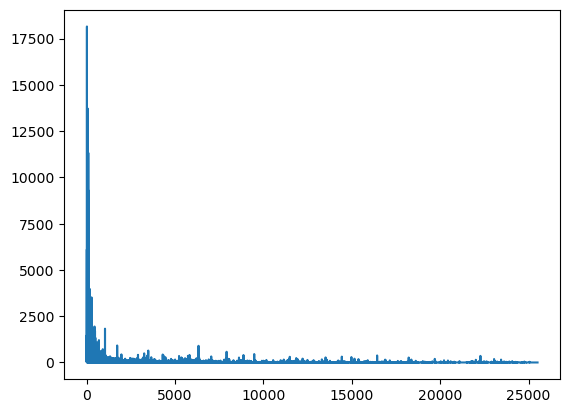

In [266]:
plt.plot(counts)

In [270]:
from statistics import mode, fmean

print(f'''Max word count: {max(counts)}
Min word count: {min(counts)}
Mode word count: {mode(counts)}
Mean word count: {fmean(counts)}''')

Max word count: 18155
Min word count: 1
Mode word count: 1
Mean word count: 19.92607400439009


In [292]:
final_dictionary = [w for w in counter if 5 <= counter[w] <= 250]

In [293]:
len(final_dictionary)

7410

In [294]:
final_dictionary[:5]

['замечательный', 'находка', 'сыворотка', 'питательный', 'floresan']

In [295]:
final_dictionary[654:659]

['распределять', 'равномерно', 'сильный', 'едва', 'держаться']

In [296]:
reviewDf['review'] = reviewDf['review'].apply(lambda x: [w for w in x if w in final_dictionary])

In [297]:
reviewDf.head(5)

,topic,subtopic,product name,review
0,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[замечательный, находка, сыворотка, питательны..."
1,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[обожать, авокадо, замечать, товар, изображени..."
2,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[сутки, протестировать, сыворотка, флоресать, ..."
3,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[сутки, дорогой, читатель, назад, приобретать,..."
4,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"[сыворотка, рекомендация, уж, хвалить, специал..."


In [299]:
reviewDf.to_csv('review_df.csv', sep='\t')

LSA model
---

In [6]:
! pip install gensim

**Немного преобразований при считывании файла**

In [1]:
import pandas as pd

In [4]:
reviewDf = pd.read_csv('review_df.csv', sep='\t', header=0, index_col=0)

In [5]:
reviewDf.head(5)

,topic,subtopic,product name,review
0,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"['замечательный', 'находка', 'сыворотка', 'пит..."
1,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"['обожать', 'авокадо', 'замечать', 'товар', 'и..."
2,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"['сутки', 'протестировать', 'сыворотка', 'флор..."
3,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"['сутки', 'дорогой', 'читатель', 'назад', 'при..."
4,Красота и здоровье,Ухаживающая косметика,Сыворотка для лица Floresan (Флоресан) Формула...,"['сыворотка', 'рекомендация', 'уж', 'хвалить',..."


In [22]:
import re

def str_to_list(l_str):
    return re.findall(r'\'(\S+)\'', l_str)

In [24]:
reviewDf['review'] = reviewDf['review'].apply(str_to_list)

In [26]:
reviewDf.review[4:6]

4    [сыворотка, рекомендация, уж, хвалить, специал...
5    [привет, милый, целое, сегодня, сыворотка, аво...
Name: review, dtype: object

**Импорт гензима и настройка модели**

In [7]:
from gensim import corpora, models

In [27]:
dictionary = corpora.Dictionary(reviewDf['review'])

In [29]:
corpus = [dictionary.doc2bow(text) for text in reviewDf['review']]

In [30]:
tfidf_model = models.TfidfModel(corpus)

In [31]:
tfidf = tfidf_model[corpus]

**Пробуем разделить на 10 тем, как и было на сайте**

In [36]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=10)

In [37]:
corpus_lsi = lsi[tfidf]

In [39]:
lsi.show_topics(num_words=5)

[(0,
  '-0.067*"молоко" + -0.063*"сковородка" + -0.061*"сыр" + -0.059*"касса" + -0.058*"автомобиль"'),
 (1,
  '-0.128*"молоко" + -0.123*"томат" + -0.119*"сыр" + 0.117*"русалочка" + -0.107*"вяленый"'),
 (2,
  '-0.474*"овуляция" + -0.383*"фолликулометрия" + -0.336*"цикл" + -0.323*"узи" + -0.305*"фолликул"'),
 (3,
  '0.236*"kuchen" + 0.228*"royal" + 0.170*"касса" + 0.154*"нож" + 0.152*"столовый"'),
 (4,
  '0.241*"вокзал" + -0.241*"kuchen" + -0.233*"royal" + 0.177*"речной" + -0.165*"нож"'),
 (5,
  '0.270*"вокзал" + 0.217*"сыр" + 0.197*"речной" + 0.193*"томат" + 0.176*"вяленый"'),
 (6,
  '0.282*"касса" + 0.265*"приложение" + 0.256*"кошелек" + 0.249*"qiwi" + 0.189*"киви"'),
 (7,
  '-0.281*"вокзал" + 0.240*"сковородка" + -0.205*"речной" + -0.176*"kuchen" + -0.171*"royal"'),
 (8,
  '0.325*"сковородка" + -0.293*"сыр" + 0.200*"покрытие" + -0.177*"автомобиль" + -0.167*"kuchen"'),
 (9,
  '-0.296*"сыр" + -0.274*"ножницы" + -0.198*"сыворотка" + 0.191*"молоко" + -0.161*"косичка"')]

**Кажется,** что лучше всего определились темы 2 и 6

In [41]:
lsi.show_topic(6, topn=25)

[('касса', 0.2821888286531762),
 ('приложение', 0.2654216880287753),
 ('кошелек', 0.25634492628282357),
 ('qiwi', 0.24905797154743742),
 ('киви', 0.18869997152766835),
 ('сковородка', -0.17352733948952614),
 ('телефон', 0.1688204017782322),
 ('кошелёк', 0.16417443724125563),
 ('комиссия', 0.15961431739075538),
 ('перевод', 0.14395961062570314),
 ('покрытие', -0.12426234881092511),
 ('статус', 0.11760208187826501),
 ('деньги', 0.1060796838709905),
 ('номер', 0.10396807873073788),
 ('мобильный', 0.10010659364835589),
 ('банк', 0.09946571001827079),
 ('ножницы', -0.09787668354590828),
 ('выводить', 0.09146103206065315),
 ('вокзал', -0.09140708173695512),
 ('автомобиль', -0.08151976452554124),
 ('платёж', 0.0792799487967423),
 ('виртуальный', 0.07819159615286837),
 ('сумма', 0.0780004403609849),
 ('система', 0.0756376169397907),
 ('резина', -0.0749410967192127)]

**Сделаем декомпозицию векторов наших тем и визуализируем**

In [46]:
from sklearn.decomposition import PCA

lsi_vectors_pca = PCA(n_components=2).fit_transform(lsi.get_topics())

In [ ]:
! pip install bokeh

In [65]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='green',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [69]:
top_20_words_for_topic = []
for i in range(10):
    top_list = [w for w, _ in lsi.show_topic(i, topn=20)]
    top_20_words_for_topic.append(top_list)
top_20_words = [f'topic {i}=' + '\n'.join(top_20_words_for_topic[i]) for i in range(10)]

In [70]:
import matplotlib.pyplot as plt
draw_vectors(lsi_vectors_pca[:, 0], lsi_vectors_pca[:, 1], token=top_20_words)
plt.show()

Слова из топа мало, что говорят о распределении топиков. Они все также хороши для тем 2 и 6. Причем видно, что тема 6 наиболее хорошо отделилась от остальных. 

Еще 9 тема выделяется, но по топ-словам этого не скажешь.

In [71]:
from gensim.models import CoherenceModel

In [73]:
coh_model_bw = CoherenceModel(model = lsi,
                                  texts = reviewDf['review'],
                                  dictionary = dictionary,
                                  coherence = 'c_v'
                                 )
coh_score = coh_model_bw.get_coherence()
print(coh_score)

0.48882733252365745


На 10 тем разделяется не очень, как видно

In [74]:
for i in range(5, 21):
    lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=i)
    coh_model_bw = CoherenceModel(model = lsi,
                                  texts = reviewDf['review'],
                                  dictionary = dictionary,
                                  coherence = 'c_v'
                                 )
    coh_score = coh_model_bw.get_coherence()
    print('Topic N', i, '\t', coh_score)

Topic N 5 	 0.4403050530712361
Topic N 6 	 0.45038197981436884
Topic N 7 	 0.5236055213707934
Topic N 8 	 0.47499335408848914
Topic N 9 	 0.5417356453586281
Topic N 10 	 0.4412258052891718
Topic N 11 	 0.4449979520210018
Topic N 12 	 0.4458760319093084
Topic N 13 	 0.39269931675639835
Topic N 14 	 0.4417038873253273
Topic N 15 	 0.42569152650134445
Topic N 16 	 0.46183194455438253
Topic N 17 	 0.41561810908866403
Topic N 18 	 0.47999454879693115
Topic N 19 	 0.4778236936288291
Topic N 20 	 0.453926582844669


Более оптимальное количество топиков 9. Ради интереса попробуем еще посмотреть значение метрики для количества категорий в нашем датасете (их 26)

In [75]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=26)
coh_model_bw = CoherenceModel(model = lsi,
                              texts = reviewDf['review'],
                              dictionary = dictionary,
                              coherence = 'c_v'
                             )
coh_score = coh_model_bw.get_coherence()
print(coh_score)

0.4710866487588462


Визуализируем разделение тем векторов для 9 тем

In [78]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=9)
lsi_vectors_pca = PCA(n_components=2).fit_transform(lsi.get_topics())

top_20_words_for_topic = []
for i in range(9):
    top_list = [w for w, _ in lsi.show_topic(i, topn=20)]
    top_20_words_for_topic.append(top_list)
top_20_words = [f'topic {i}=' + '\n'.join(top_20_words_for_topic[i]) for i in range(9)]

In [79]:
draw_vectors(lsi_vectors_pca[:, 0], lsi_vectors_pca[:, 1], token=top_20_words)
plt.show()

Визуально теперь действительно разделяется лучше. Наиболее понятен по топ словам все еще топик 6 (крайний справа), которому свойственна техническая и автомобильная лексика

LDA model
---

In [80]:
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=9)

In [ ]:
! pip install pyLDAvis

In [82]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=lda.id2word)

C:\Users\PC Natalya\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\PC Natalya\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


__LDA для 9 тем,__ работает не очень понятно. Темы как-то смешаны. Например, "Ася" в теме 8, "Тургенев" в теме 7

In [83]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002629 -0.023058       1        1  23.308173
4     -0.016307 -0.011406       2        1  18.858526
3     -0.024613  0.003551       3        1  12.181484
7      0.013807 -0.002909       4        1  11.434404
5     -0.005635  0.014497       5        1   8.895547
0      0.021934  0.016946       6        1   8.311454
2      0.004998 -0.014503       7        1   6.762624
8      0.014332 -0.001067       8        1   5.715631
6     -0.011145  0.017950       9        1   4.532158, topic_info=            Term        Freq       Total Category  logprob  loglift
3876     ножницы  119.000000  119.000000  Default  30.0000  30.0000
6415       томат   99.000000   99.000000  Default  29.0000  29.0000
4797  сковородка  122.000000  122.000000  Default  28.0000  28.0000
7159    кастрюля   92.000000   92.000000  Default  27.0000  27.0000
7068     котлета   85.000000   85.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3128    просмотр    6.328822   98.191282   Topic9  -7.2998   0.3522
5715         сыр    6.493528  136.162706   Topic9  -7.2741   0.0509
4756      творог    6.329523  123.472554   Topic9  -7.2997   0.1232
2283       синий    6.086761   67.019235   Topic9  -7.3388   0.6951
58     добавлять    6.115827   85.601803   Topic9  -7.3341   0.4551

[617 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3106      1  0.169638  anti-blemishes
3106      2  0.508913  anti-blemishes
3106      3  0.042409  anti-blemishes
3106      4  0.042409  anti-blemishes
3106      5  0.042409  anti-blemishes
...     ...       ...             ...
6476      5  0.295072               ᴥ
6476      6  0.073768               ᴥ
6476      7  0.073768               ᴥ
6476      8  0.073768               ᴥ
6476      9  0.073768               ᴥ

[4347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 8, 6, 1, 3, 9, 7])

In [84]:
for i in range(5, 21):
    lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=i)
    coh_model_bw = CoherenceModel(model = lda,
                                  texts = reviewDf['review'],
                                  dictionary = dictionary,
                                  coherence = 'c_v'
                                 )
    coh_score = coh_model_bw.get_coherence()
    print('Topic N', i, '\t', coh_score)

Topic N 5 	 0.5657866694939535
Topic N 6 	 0.5638021624832027
Topic N 7 	 0.5760221105701709
Topic N 8 	 0.5343056786119018
Topic N 9 	 0.5391735131443444
Topic N 10 	 0.5426229594227007
Topic N 11 	 0.5376367257917057
Topic N 12 	 0.5521529927866969
Topic N 13 	 0.5319301498755773
Topic N 14 	 0.5612489807618021
Topic N 15 	 0.5404707108786326
Topic N 16 	 0.5528169817878741
Topic N 17 	 0.559077648018902
Topic N 18 	 0.5489083339214725
Topic N 19 	 0.5454209170819305
Topic N 20 	 0.5475022232129411


Более оптимальное количество тем теперь 7. Визуализируем их

In [85]:
pyLDAvis.enable_notebook()
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=7)
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=lda.id2word)

C:\Users\PC Natalya\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [86]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.015248 -0.006942       1        1  23.094857
0      0.022544 -0.004305       2        1  17.967714
5      0.003120  0.009354       3        1  16.760146
2     -0.010775  0.009138       4        1  12.241059
4     -0.002325 -0.004208       5        1  10.837013
3     -0.008752  0.019836       6        1  10.082974
6     -0.019061 -0.022874       7        1   9.016237, topic_info=            Term        Freq       Total Category  logprob  loglift
5715         сыр  119.000000  119.000000  Default  30.0000  30.0000
7299   кофеварка   70.000000   70.000000  Default  29.0000  29.0000
7180     горошек   85.000000   85.000000  Default  28.0000  28.0000
1677       тёрка   59.000000   59.000000  Default  27.0000  27.0000
4756      творог  112.000000  112.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
290        часто   12.463232   94.032997   Topic7  -7.3100   0.3853
1276         муж   12.281109   90.119277   Topic7  -7.3247   0.4131
56        деньги   12.503080  111.540334   Topic7  -7.3068   0.2177
7068     котлета   12.357326  102.273146   Topic7  -7.3185   0.2927
560   советовать   12.356218  109.635761   Topic7  -7.3186   0.2231

[473 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
7026      1  0.642729   adam
7026      2  0.075615   adam
7026      3  0.075615   adam
7026      4  0.113423   adam
7026      5  0.037808   adam
...     ...       ...    ...
792       3  0.085564  яркий
792       4  0.096259  яркий
792       5  0.074868  яркий
792       6  0.074868  яркий
792       7  0.053477  яркий

[2660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 3, 5, 4, 7])

Разделилось более красиво, но слова все еще не очень позволяют четко выделить темы. Возможно, стоило лучше предобработать тексты, потому что попадаются в частности и предлоги.

Почитаем тексты по разделенным топикам
---

1. Для LSI


2. Для LDA

In [99]:
corpus_lsi = lsi[tfidf]

In [100]:
len(corpus_lsi)

1528

In [103]:
import random
rand_rvws = sorted(random.sample(range(0, 1528), 20))

In [117]:
topic_mark_review = pd.DataFrame(columns=['mark', 'site_tag', 'review_short'])

In [118]:
for i in rand_rvws:
    mark = sorted(corpus_lsi[i], key=lambda x: x[1], reverse=True)[0][0]
    review_short = ' '.join(reviewDf['review'].loc[i][:55])
    site_tag = reviewDf['topic'].loc[i]
    topic_mark_review.loc[i] = [mark, site_tag, review_short]

In [119]:
topic_mark_review

,mark,site_tag,review_short
27,5,Красота и здоровье,начать дизайн маркетолог постараться слава сти...
62,0,Красота и здоровье,привет казаться неплохой бюджетный сегмент кон...
172,0,Детское,здравствовать аквариум морской обезьянка узнат...
268,0,Детское,жалеть приобретать почему-то москва редкость в...
289,2,Детское,сутки столкнуться когда-то почитать понять зач...
312,0,Техника,привет моющий специфический счастие женщина да...
405,0,Техника,xiaomi deerma deerma старенький длинный шланг ...
504,0,Туризм,товарищ восторг москва куда захотеть возвращат...
643,0,Животные,марка феликс уважать новинка воспринять рассма...
826,0,Кино,привет вырасти диснеевский мультсериал любимый...


In [111]:
topic_mark_review['mark'].value_counts()

0    11
8     3
7     2
5     1
2     1
4     1
1     1
Name: mark, dtype: int64

In [138]:
for d in topic_mark_review[topic_mark_review['mark'] == 0][['review_short', 'site_tag']].values:
    print(d[0])
    print(d[1], '===')

привет казаться неплохой бюджетный сегмент конкретно столь многообещающий яблоко мятый эффект бальзам кондиционер увы разочаровать часть пенообразование ооо насколько концерт тестировать продукция животное классно объем мл фикс прайс местный уютный магазинчик всякий хозяйственный душ вопрос кажется порядок август назначение бальзам тип уход стиль вытянутый далеко формат топ дозатор жидкость голубой видно сквозь прозрачный пластик ёмкость
Красота и здоровье ===
здравствовать аквариум морской обезьянка узнать реклама канал настолько необычный отличаться прочий рекламный ролик начать просить кнопка аквариум sea monkeys artemia salina ехать морской обезьянка симанкиса распространить мир поступать честно среди мир игрушка ожидаться обычно заранее сайт близкий ждать sea monkeys озон сожаление книжный лабиринт продаваться заказ дешёвый скидка си манкиса продаваться многий сколько морской обезьянка
Детское ===
жалеть приобретать почему-то москва редкость всякий результат привезти ростов-на-дон

**Видно, что темы с сайта для марки 0 оказываются все перемешаны - здесь есть отзывы и про косметику, и про продукты, и про технику**

In [139]:
for d in topic_mark_review[topic_mark_review['mark'] == 8][['review_short', 'site_tag']].values:
    print(d[0])
    print(d[1], '===')

хрупкий девушка возможно комплекс наполеон носить обувь высокий длинный вызывать восхищение недоумение длина сантиметр ширина сантиметр автомобиль внедорожник высокий посадка внедорожный автомобиль увеличить водитель право урок учёба посещать благодаря превосходный авто уаз патриот габарит багажник литр столько взгляд удивлённый водитель хрупкий девушка руль мощный сложно справиться новичок крутой ощущение сокровище роскошный надёжный вместительный супер проходимость
Авто ===
уаз патриот браться лес рыбалка охота ягодный сезон расчёт возможный следующий удачный сезон появиться возможность минимальный шанс встретить конкурент сбор ягода постепенно привыкать разница пежо огромный радовать коробка автомат куча помощник особенно устойчивость надёжность оно понятно проходимость положительный эмоция впервые руль появляться чувство свобода уверенность наверно будущее ждать неприятность предстоящий ремонт излишний уверенность рад
Авто ===
частый ездить женщина стаж водительский десять ездить с

Марка 8 на рандомной выборке вполне хорошо сочетается с темой Авто

**То же, но для LDA**

! Рассмотрим на тех же текстах

In [140]:
corpus_lda = lda[tfidf]

In [141]:
topic_mark_review = pd.DataFrame(columns=['mark', 'site_tag', 'review_short'])

In [142]:
for i in rand_rvws:
    mark = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)[0][0]
    review_short = ' '.join(reviewDf['review'].loc[i][:55])
    site_tag = reviewDf['topic'].loc[i]
    topic_mark_review.loc[i] = [mark, site_tag, review_short]

In [143]:
topic_mark_review

,mark,site_tag,review_short
27,3,Красота и здоровье,начать дизайн маркетолог постараться слава сти...
62,1,Красота и здоровье,привет казаться неплохой бюджетный сегмент кон...
172,0,Детское,здравствовать аквариум морской обезьянка узнат...
268,2,Детское,жалеть приобретать почему-то москва редкость в...
289,4,Детское,сутки столкнуться когда-то почитать понять зач...
312,4,Техника,привет моющий специфический счастие женщина да...
405,6,Техника,xiaomi deerma deerma старенький длинный шланг ...
504,2,Туризм,товарищ восторг москва куда захотеть возвращат...
643,1,Животные,марка феликс уважать новинка воспринять рассма...
826,0,Кино,привет вырасти диснеевский мультсериал любимый...


In [144]:
topic_mark_review['mark'].value_counts()

1    4
2    4
3    3
4    3
6    3
0    2
5    1
Name: mark, dtype: int64

In [145]:
for d in topic_mark_review[topic_mark_review['mark'] == 1][['review_short', 'site_tag']].values:
    print(d[0])
    print(d[1], '===')

привет казаться неплохой бюджетный сегмент конкретно столь многообещающий яблоко мятый эффект бальзам кондиционер увы разочаровать часть пенообразование ооо насколько концерт тестировать продукция животное классно объем мл фикс прайс местный уютный магазинчик всякий хозяйственный душ вопрос кажется порядок август назначение бальзам тип уход стиль вытянутый далеко формат топ дозатор жидкость голубой видно сквозь прозрачный пластик ёмкость
Красота и здоровье ===
марка феликс уважать новинка воспринять рассматривать желе вполне достойный существовать лакомство строго ограниченный плохой произойти кормить ежедневно пакет вкусовой рецептор испортить добавка вызвать аллергия касаться личный опыт заметить съесть аппетит вылизывать выбирать кусочек съесть добавка попросить известный интернет-магазин доставка дом розничный сеть встречать стоимость штука
Животные ===
житель век событие произойти окрестность немногое рано заметить необычный марс газ вскоре земля упасть видимость многочисленный ок

**Как видно, марка не согласовывается с темами сайта. Но впрочем беглым взглядом можно отметить большое количество описательных прилагательных в текстах.**

In [149]:
for d in topic_mark_review[topic_mark_review['mark'] == 3][['review_short', 'site_tag']].values:
    print(d[0])
    print(d[1], '===')

начать дизайн маркетолог постараться слава стиль отдельно отметить особо дезодорант наноситься липкость чувство сухость пачкать одежда хватать содержать спирт миниатюрный помещаться сумочка
Красота и здоровье ===
привет поделиться мнение шикарный комедия заставлять смеяться настолько лёгкий прекрасный актёр деловой предложение незабываемый выйти март состоять получать удовольствие романтический комедия офис вместо подруга свидание вслепую генеральный директор компания скрывать личность поражать героиня простой девушка скромный внешность классный профессионал однако уверить причина постоянно врать прятаться прежде подумать характер поведение вызывать море смех нелепый ситуация реальный
Кино ===
творог крупный зёрнышко сыворотка нежный сливочный суть добавлять джема малина кажется удачный косточка зуб приятно застревать сочетание вполне подходящий желание джема добавлять отдельный контейнер уж дорого объём
Продукты ===


**В этом случае что-то сказать затруднительно**

**В итоге** лучше всего себя проявила модель LSI с подобранными 9 топиками